# Finding the Weights in Gaussian Quadrature

In [1]:
import numpy as np
import numpy.linalg as la
import scipy.special as sps
import matplotlib.pyplot as pt

Here's a utility routine to do biseciton, to use below:

In [2]:
def bisection(f, a, b, tol=1e-14):
    assert np.sign(f(a)) != np.sign(f(b))
    while b-a > tol:
        m = a + (b-a)/2
        fm = f(m)
        if np.sign(f(a)) != np.sign(fm):
            b = m
        else:
            a = m
            
    return m

Set the number of nodes:

In [3]:
n = 5

### Node selection: Plain Gauss

Gauss nodes are the roots of the $n$th Legendre polynomial $P_n$:

[-0.90617985 -0.53846931  0.          0.53846931  0.90617985]


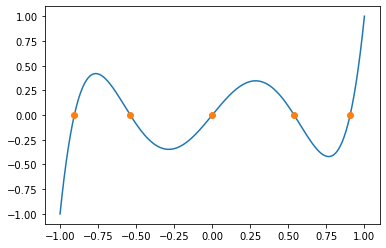

In [4]:
nodes = sps.legendre(n).weights[:, 0]

mesh = np.linspace(-1, 1, 300)

pt.plot(mesh, sps.eval_legendre(n, mesh))
pt.plot(nodes, 0*nodes, "o")
print(nodes)

### Node Selection: Gauss-Lobatto

Gauss-Lobatto nodes are (except for the endpoints) the roots of $P_{n-1}'$:

(See [here](https://en.wikipedia.org/wiki/Legendre_polynomials#Additional_properties_of_Legendre_polynomials) or [here](http://dlmf.nist.gov/18.9.17) for a formula for $P_n'$.)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


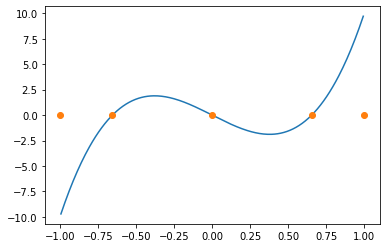

In [5]:
def eval_legendre_deriv(n, x):
    return (
        (x*sps.eval_legendre(n, x) - sps.eval_legendre(n-1, x))
        /
        ((x**2-1)/n))

brackets = sps.legendre(n-1).weights[:, 0]

nodes = np.zeros(n)
nodes[0] = -1
nodes[-1] = 1

from functools import partial

# Use the fact that the roots of P_{n-1} bracket the roots of P_{n-1}':
for i in range(n-2):
    nodes[i+1] = bisection(
        partial(eval_legendre_deriv, n-1),
        brackets[i], brackets[i+1])

mesh = np.linspace(-1, 1, 300)

pt.plot(mesh, eval_legendre_deriv(n-1, mesh))
pt.plot(nodes, 0*nodes, "o")

### Node Selection: Gauss-Radau

For Gauss-Radau (with the left endpoint included), the nodes are the roots of the following function:

[-1.         -0.72048027 -0.16718086  0.44631397  0.88579161]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


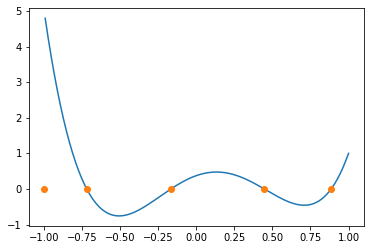

In [6]:
def radau_func(n, x):
    return (
        (sps.eval_legendre(n-1, x) + sps.eval_legendre(n, x))
        /
        (1+x))

brackets = sps.legendre(n).weights[:, 0]

nodes = None
# Root finding left as an exercise for the reader. :)
nodes = np.zeros(n)
nodes[0] = -1

from functools import partial

# Use the fact that the roots of P_{n-1} bracket the roots of P_{n-1}':
for i in range(n-1):
    nodes[i+1] = bisection(
        partial(radau_func, n),
        brackets[i], brackets[i+1])

mesh = np.linspace(-1, 1, 300)
pt.plot(mesh, radau_func(n, mesh))
pt.plot(nodes, 0*nodes, "o")
print(nodes)

### Finding the weights

Use method of undetermined coefficients to find the interpolatory quadrature rule for `nodes`:

In [ ]:
max_degree = len(nodes) - 1
powers = np.arange(max_degree+1)

Vt = nodes ** powers.reshape(-1, 1)

a, b = -1, 1
rhs = 1/(powers+1) * (b**(powers+1) - a**(powers+1))

weights = la.solve(Vt, rhs)

Now compare the approximate integrals of monomials from our rule with the true answers:

In [ ]:
for i in range(2*n + 1):
    approx = weights @ nodes**i
    true = 1/(i+1)*(1. - (-1)**(i+1))
    
    print("Error at degree %d: %g" % (i, approx-true))